# Ptychographic Reconstructions

Ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities in the far-field:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations are given by:
1. Overlap-Projection Constraint, between Object(s) and Probe(s)
2. Fourier-Projection Constraint, between Exit-Wave and Measured Diffraction Intensities
3. Gradient-Descent Update for Object(s) and (optionally) Probe(s)

## Multislice Reconstructions

In this tutorial, we'll how for sufficiently thick samples the multiplicative assumption for our exit wave forward model

$$
\psi_{j \boldsymbol{r}} = P_{\boldsymbol{r}} \times O_{\boldsymbol{r}-\boldsymbol{R}_j}
$$

breaks down, and how [multislice ptychography](https://doi.org/10.1364/JOSAA.29.001606) accounts for this by including free-space propagation in its forward model:

$$
\begin{aligned}
\psi_{j \boldsymbol{r}}^n &= P^n_{\boldsymbol{r}} \times O^n_{\boldsymbol{r}-\boldsymbol{R}_j} \\
P^{n+1}_{\boldsymbol{r}}  &= \mathrm{Prop}_{\Delta Z_n}\left[ \psi_{j \boldsymbol{r}}^n \right]
\end{aligned}
$$

We'll consider the same slab of [110] STO, but three times thicker:

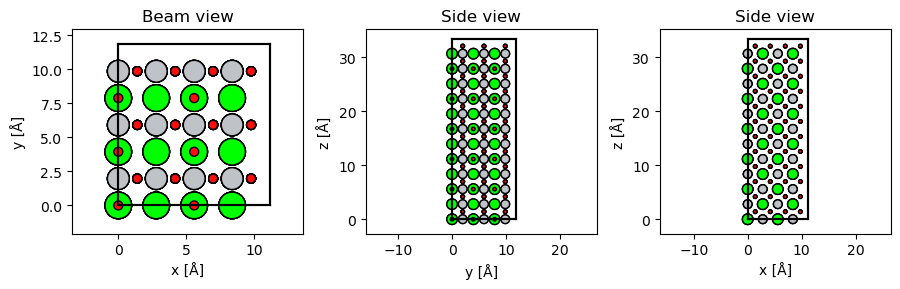

In [4]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

STO_unit_cell   = read('data/SrTiO3.cif')
STO_atoms       = surface(STO_unit_cell, (1,1,0), 4, periodic=True)*(2,3,1)
STO_atoms_thick      = STO_atoms *(1,1,3)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))

show_atoms(STO_atoms_thick, ax = ax1, title = 'Beam view')
show_atoms(STO_atoms_thick, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(STO_atoms_thick, ax = ax3, plane = 'xz', title = 'Side view')

fig.tight_layout();

In [8]:
from abtem import Potential, FrozenPhonons, Probe, CTF
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan

frozen_phonons_thick = FrozenPhonons(STO_atoms_thick, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
potential_thick      = Potential(frozen_phonons_thick,
                                 sampling=0.02,
                                 device='gpu',
                                 projection='infinite',
                                 parametrization='kirkland').build()

ctf             = CTF(parameters={'C10': -75,'C12': 20, 'phi12': 0.785,'C30':-7e4},semiangle_cutoff=24)
probe           = Probe(semiangle_cutoff=24,
                        energy=200e3,
                        ctf=ctf,
                        device='gpu')
probe.match_grid(potential_thick)

pixelated_detector  = PixelatedDetector(max_angle=120)
gridscan            = GridScan((0,0), potential_thick.extent, sampling = 0.9*probe.ctf.nyquist_sampling)
measurement_thick   = probe.scan(gridscan,pixelated_detector,potential_thick)

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

First, let's see Regularized-PIE breakdown already for a sample of this thickness:

In [10]:
from abtem.reconstruct import RegularizedPtychographicOperator

msrpie_reconstruction_ptycho_operator = RegularizedPtychographicOperator(measurement_thick,
                                                                         semiangle_cutoff=24,
                                                                         energy=200e3,
                                                                         device='gpu',
                                                                         parameters={'object_px_padding':(0,0)}).preprocess()

msrpie_objects, msrpie_probes, msrpie_positions, msrpie_sse = msrpie_reconstruction_ptycho_operator.reconstruct(
    max_iterations = 5,
    random_seed=1,
    verbose = True,
    return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 3.734e-06
----Iteration 1, SSE = 1.832e-06
----Iteration 2, SSE = 1.819e-06
----Iteration 3, SSE = 1.799e-06
----Iteration 4, SSE = 1.795e-06


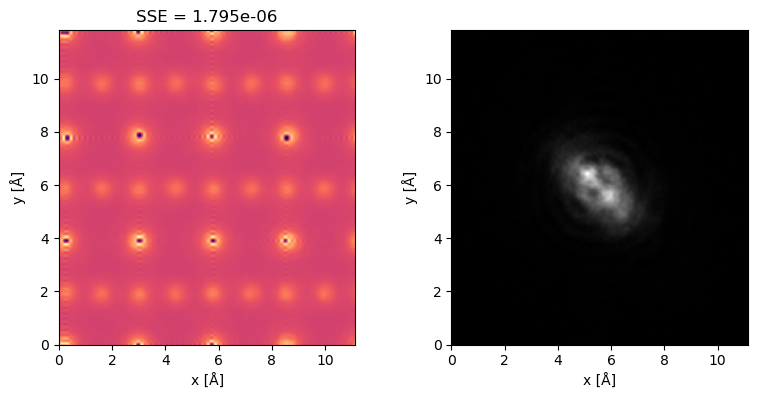

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

msrpie_objects[-1].angle().interpolate(potential_thick.sampling).show(cmap='magma',ax=ax1,title=f"SSE = {float(msrpie_sse[-1]):.3e}")
msrpie_probes[-1].intensity().interpolate(potential_thick.sampling).show(ax=ax2)

fig.tight_layout();

Indeed, the e-PIE algorithm does pretty poorly on the thicker sample.  
Let's see if multislice-PIE performs better. We'll use three evenly-spaced slices.

For this, we introduce another object called `MultislicePtychographicOperator`, which accepts two additional parameters: `num_slices` and `slice_thicknesses`

In [12]:
from abtem.reconstruct import MultislicePtychographicOperator

slice_thicknesses = STO_atoms_thick.cell.lengths()[-1]/3
multislice_reconstruction_ptycho_operator = MultislicePtychographicOperator(measurement_thick,
                                                                            semiangle_cutoff=24,
                                                                            energy=200e3,
                                                                            num_slices = 3,
                                                                            slice_thicknesses = slice_thicknesses,
                                                                            device='gpu',
                                                                            parameters={'object_px_padding':(0,0)}).preprocess()

mspie_objects, mspie_probes, mspie_positions, mspie_sse = multislice_reconstruction_ptycho_operator.reconstruct(
    max_iterations = 5,
    verbose=True,
    random_seed=1,
    return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Multislice PIE for 11750 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 2.991e-06
----Iteration 1, SSE = 4.728e-07
----Iteration 2, SSE = 3.286e-07
----Iteration 3, SSE = 2.770e-07
----Iteration 4, SSE = 2.606e-07


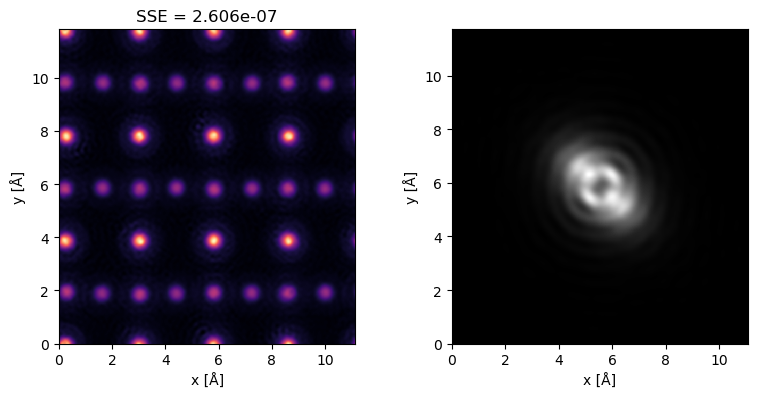

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

mspie_objects[-1].angle().sum(0).interpolate(potential_thick.sampling).show(cmap='magma',ax=ax1,title=f"SSE = {float(mspie_sse[-1]):.3e}")
mspie_probes[-1][0].intensity().interpolate(potential_thick.sampling).show(ax=ax2)

fig.tight_layout();

This is indeed significantly better, albeit more computationally intensive and often numerically challenging to converge